# Import and misc

In [ ]:
!pip install torchaudio==0.9.1

In [ ]:
from typing import Tuple, Union, List, Callable, Optional
from tqdm import tqdm
from itertools import islice, product
from copy import deepcopy

import random
import pathlib
import dataclasses

import numpy as np
import pandas as pd

import torch
import torch.nn.functional as F
from torch import nn
from torch import distributions
from torch.utils.data import DataLoader, Dataset, WeightedRandomSampler
from torch.nn.utils.rnn import pad_sequence

import torchaudio
from IPython import display as display_

In [ ]:
def fix_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

SEED = 3407 # is all you need

# Task

In this notebook we will implement a model for finding a keyword in a stream.

We will implement the version with CRNN because it is easy and improves the model. 
(from https://www.dropbox.com/s/22ah2ba7dug6pzw/KWS_Attention.pdf)

In [ ]:
@dataclasses.dataclass
class TaskConfig:
    keyword: str = 'sheila'  # We will use 1 key word -- 'sheila'
    batch_size: int = 128
    learning_rate: float = 3e-4
    weight_decay: float = 1e-5
    num_epochs: int = 20
    n_mels: int = 40
    cnn_out_channels: int = 8
    kernel_size: Tuple[int, int] = (5, 20)
    stride: Tuple[int, int] = (2, 8)
    hidden_size: int = 64
    gru_num_layers: int = 2
    bidirectional: bool = False
    num_classes: int = 2
    sample_rate: int = 16000
    device: torch.device = torch.device(
        'cuda:0' if torch.cuda.is_available() else 'cpu')

# Data

In [ ]:
!wget http://download.tensorflow.org/data/speech_commands_v0.01.tar.gz -O speech_commands_v0.01.tar.gz
!mkdir speech_commands && tar -C speech_commands -xvzf speech_commands_v0.01.tar.gz 1> log

--2021-11-22 09:55:58--  http://download.tensorflow.org/data/speech_commands_v0.01.tar.gz
Resolving download.tensorflow.org (download.tensorflow.org)... 74.125.195.128, 2607:f8b0:400e:c09::80
Connecting to download.tensorflow.org (download.tensorflow.org)|74.125.195.128|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1489096277 (1.4G) [application/gzip]
Saving to: ‘speech_commands_v0.01.tar.gz’

speech_commands_v0. 100%[===================>]   1.39G   144MB/s    in 9.3s    

2021-11-22 09:56:08 (153 MB/s) - ‘speech_commands_v0.01.tar.gz’ saved [1489096277/1489096277]



In [ ]:
class SpeechCommandDataset(Dataset):

    def __init__(
        self,
        transform: Optional[Callable] = None,
        path2dir: str = None,
        keywords: Union[str, List[str]] = None,
        csv: Optional[pd.DataFrame] = None
    ):        
        self.transform = transform

        if csv is None:
            path2dir = pathlib.Path(path2dir)
            keywords = keywords if isinstance(keywords, list) else [keywords]
            
            all_keywords = [
                p.stem for p in path2dir.glob('*')
                if p.is_dir() and not p.stem.startswith('_')
            ]

            triplets = []
            for keyword in all_keywords:
                paths = (path2dir / keyword).rglob('*.wav')
                if keyword in keywords:
                    for path2wav in paths:
                        triplets.append((path2wav.as_posix(), keyword, 1))
                else:
                    for path2wav in paths:
                        triplets.append((path2wav.as_posix(), keyword, 0))
            
            self.csv = pd.DataFrame(
                triplets,
                columns=['path', 'keyword', 'label']
            )

        else:
            self.csv = csv
    
    def __getitem__(self, index: int):
        instance = self.csv.iloc[index]

        path2wav = instance['path']
        wav, sr = torchaudio.load(path2wav)
        wav = wav.sum(dim=0)
        
        if self.transform:
            wav = self.transform(wav)

        return {
            'wav': wav,
            'keywors': instance['keyword'],
            'label': instance['label']
        }

    def __len__(self):
        return len(self.csv)

In [ ]:
dataset = SpeechCommandDataset(
    path2dir='speech_commands', keywords=TaskConfig.keyword
)

In [ ]:
dataset.csv.sample(5)

,path,keyword,label
22207,speech_commands/seven/3d53244b_nohash_3.wav,seven,0
43640,speech_commands/nine/35d1b6ee_nohash_2.wav,nine,0
61173,speech_commands/cat/f35eedd7_nohash_2.wav,cat,0
29751,speech_commands/six/cd7f8c1b_nohash_0.wav,six,0
12807,speech_commands/bed/e41a903b_nohash_0.wav,bed,0


### Augmentations

In [ ]:
class AugsCreation:

    def __init__(self):
        self.background_noises = [
            'speech_commands/_background_noise_/white_noise.wav',
            'speech_commands/_background_noise_/dude_miaowing.wav',
            'speech_commands/_background_noise_/doing_the_dishes.wav',
            'speech_commands/_background_noise_/exercise_bike.wav',
            'speech_commands/_background_noise_/pink_noise.wav',
            'speech_commands/_background_noise_/running_tap.wav'
        ]

        self.noises = [
            torchaudio.load(p)[0].squeeze()
            for p in self.background_noises
        ]

    def add_rand_noise(self, audio):

        # randomly choose noise
        noise_num = torch.randint(low=0, high=len(
            self.background_noises), size=(1,)).item()
        noise = self.noises[noise_num]

        noise_level = torch.Tensor([1])  # [0, 40]

        noise_energy = torch.norm(noise)
        audio_energy = torch.norm(audio)
        alpha = (audio_energy / noise_energy) * \
            torch.pow(10, -noise_level / 20)

        start = torch.randint(
            low=0,
            high=max(int(noise.size(0) - audio.size(0) - 1), 1),
            size=(1,)
        ).item()
        noise_sample = noise[start: start + audio.size(0)]

        audio_new = audio + alpha * noise_sample
        audio_new.clamp_(-1, 1)
        return audio_new

    def __call__(self, wav):
        aug_num = torch.randint(low=0, high=4, size=(1,)).item()   # choose 1 random aug from augs
        augs = [
            lambda x: x,
            lambda x: (x + distributions.Normal(0, 0.01).sample(x.size())).clamp_(-1, 1),
            lambda x: torchaudio.transforms.Vol(.25)(x),
            lambda x: self.add_rand_noise(x)
        ]

        return augs[aug_num](wav)

In [ ]:
fix_seed(SEED)

indexes = torch.randperm(len(dataset))
train_indexes = indexes[:int(len(dataset) * 0.8)]
val_indexes = indexes[int(len(dataset) * 0.8):]

train_df = dataset.csv.iloc[train_indexes].reset_index(drop=True)
val_df = dataset.csv.iloc[val_indexes].reset_index(drop=True)

In [ ]:
# Сохраним на всякий случай (для воспроизводимости)
train_df.to_csv('train.csv')
val_df.to_csv('val.csv')

In [ ]:
train_df = pd.read_csv('train.csv', index_col=0)
val_df = pd.read_csv('val.csv', index_col=0)

In [ ]:
# Sample is a dict of utt, word and label
train_set = SpeechCommandDataset(csv=train_df, transform=AugsCreation())
val_set = SpeechCommandDataset(csv=val_df)

### Sampler for oversampling:

In [ ]:
# We should provide to WeightedRandomSampler _weight for every sample_; by default it is 1/len(target)

def get_sampler(target):
    class_sample_count = np.array(
        [len(np.where(target == t)[0]) for t in np.unique(target)])   # for every class count it's number of occ.
    weight = 1. / class_sample_count
    samples_weight = np.array([weight[t] for t in target])
    samples_weight = torch.from_numpy(samples_weight)
    samples_weigth = samples_weight.float()
    sampler = WeightedRandomSampler(samples_weight, len(samples_weight))
    return sampler

In [ ]:
train_sampler = get_sampler(train_set.csv['label'].values)

In [ ]:
class Collator:
    
    def __call__(self, data):
        wavs = []
        labels = []    

        for el in data:
            wavs.append(el['wav'])
            labels.append(el['label'])

        # torch.nn.utils.rnn.pad_sequence takes list(Tensors) and returns padded (with 0.0) Tensor
        wavs = pad_sequence(wavs, batch_first=True)    
        labels = torch.Tensor(labels).long()
        return wavs, labels

###  Dataloaders

In [ ]:
# Here we are obliged to use shuffle=False because of our sampler with randomness inside.

train_loader = DataLoader(train_set, batch_size=TaskConfig.batch_size,
                          shuffle=False, collate_fn=Collator(),
                          sampler=train_sampler,
                          num_workers=2, pin_memory=True)

val_loader = DataLoader(val_set, batch_size=TaskConfig.batch_size,
                        shuffle=False, collate_fn=Collator(),
                        num_workers=2, pin_memory=True)

### Creating MelSpecs on GPU for speeeed: 

In [ ]:
class LogMelspec:

    def __init__(self, is_train, config):
        # with augmentations
        if is_train:
            self.melspec = nn.Sequential(
                torchaudio.transforms.MelSpectrogram(
                    sample_rate=config.sample_rate,
                    n_fft=400,
                    win_length=400,
                    hop_length=160,
                    n_mels=config.n_mels
                ),
                torchaudio.transforms.FrequencyMasking(freq_mask_param=15),
                torchaudio.transforms.TimeMasking(time_mask_param=35),
            ).to(config.device)

        # no augmentations
        else:
            self.melspec = torchaudio.transforms.MelSpectrogram(
                sample_rate=config.sample_rate,
                n_fft=400,
                win_length=400,
                hop_length=160,
                n_mels=config.n_mels
            ).to(config.device)

    def __call__(self, batch):
        # already on device
        return torch.log(self.melspec(batch).clamp_(min=1e-9, max=1e9))

In [ ]:
melspec_train = LogMelspec(is_train=True, config=TaskConfig)
melspec_val = LogMelspec(is_train=False, config=TaskConfig)

### Quality measurment functions:

In [ ]:
# FA - true: 0, model: 1
# FR - true: 1, model: 0

def count_FA_FR(preds, labels):
    FA = torch.sum(preds[labels == 0])
    FR = torch.sum(labels[preds == 0])
    
    # torch.numel - returns total number of elements in tensor
    return FA.item() / torch.numel(preds), FR.item() / torch.numel(preds)

In [ ]:
def get_au_fa_fr(probs, labels):
    sorted_probs, _ = torch.sort(probs)
    sorted_probs = torch.cat((torch.Tensor([0]), sorted_probs, torch.Tensor([1])))
    labels = torch.cat(labels, dim=0)
        
    FAs, FRs = [], []
    for prob in sorted_probs:
        preds = (probs >= prob) * 1
        FA, FR = count_FA_FR(preds, labels)        
        FAs.append(FA)
        FRs.append(FR)
    # plt.plot(FAs, FRs)
    # plt.show()

    # ~ area under curve using trapezoidal rule
    return -np.trapz(FRs, x=FAs)

# Model

In [ ]:
class Attention(nn.Module):

    def __init__(self, hidden_size: int):
        super().__init__()

        self.energy = nn.Sequential(
            nn.Linear(hidden_size, hidden_size),
            nn.Tanh(),
            nn.Linear(hidden_size, 1)
        )
    
    def forward(self, input):
        energy = self.energy(input)
        alpha = torch.softmax(energy, dim=-2)
        return (input * alpha).sum(dim=-2)

class CRNN(nn.Module):

    def __init__(self, config: TaskConfig):
        super().__init__()
        self.config = config

        self.conv = nn.Sequential(
            nn.Conv2d(
                in_channels=1, out_channels=config.cnn_out_channels,
                kernel_size=config.kernel_size, stride=config.stride
            ),
            nn.Flatten(start_dim=1, end_dim=2),
        )

        self.conv_out_frequency = (config.n_mels - config.kernel_size[0]) // \
            config.stride[0] + 1
        
        self.gru = nn.GRU(
            input_size=self.conv_out_frequency * config.cnn_out_channels,
            hidden_size=config.hidden_size,
            num_layers=config.gru_num_layers,
            dropout=0.1,
            bidirectional=config.bidirectional,
            batch_first=True
        )

        true_hidden = config.hidden_size * (2 if config.bidirectional else 1)
        self.attention = Attention(true_hidden)
        self.classifier = nn.Linear(true_hidden, config.num_classes)
    
    def forward(self, input):
        input = input.unsqueeze(dim=1)
        conv_output = self.conv(input).transpose(-1, -2)
        gru_output, _ = self.gru(conv_output)
        contex_vector = self.attention(gru_output)
        output = self.classifier(contex_vector)
        return output

In [ ]:
fix_seed(SEED)

config = TaskConfig()
model = CRNN(config)
model

CRNN(
  (conv): Sequential(
    (0): Conv2d(1, 8, kernel_size=(5, 20), stride=(2, 8))
    (1): Flatten(start_dim=1, end_dim=2)
  )
  (gru): GRU(144, 64, num_layers=2, batch_first=True, dropout=0.1)
  (attention): Attention(
    (energy): Sequential(
      (0): Linear(in_features=64, out_features=64, bias=True)
      (1): Tanh()
      (2): Linear(in_features=64, out_features=1, bias=True)
    )
  )
  (classifier): Linear(in_features=64, out_features=2, bias=True)
)

In [ ]:
def train_epoch(model, opt, loader, log_melspec, device):
    model.train()
    for i, (batch, labels) in tqdm(enumerate(loader), total=len(loader)):
        batch, labels = batch.to(device), labels.to(device)
        batch = log_melspec(batch)

        opt.zero_grad()

        # run model # with autocast():
        logits = model(batch)
        # we need probabilities so we use softmax & CE separately
        probs = F.softmax(logits, dim=-1)
        loss = F.cross_entropy(logits, labels)

        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 5)

        opt.step()

        # logging
        argmax_probs = torch.argmax(probs, dim=-1)
        FA, FR = count_FA_FR(argmax_probs, labels)
        acc = torch.sum(argmax_probs == labels) / torch.numel(argmax_probs)

    return acc

In [ ]:
@torch.no_grad()
def validation(model, loader, log_melspec, device):
    model.eval()

    val_losses, accs, FAs, FRs = [], [], [], []
    all_probs, all_labels = [], []
    for i, (batch, labels) in tqdm(enumerate(loader)):
        batch, labels = batch.to(device), labels.to(device)
        batch = log_melspec(batch)

        output = model(batch)
        # we need probabilities so we use softmax & CE separately
        probs = F.softmax(output, dim=-1)
        loss = F.cross_entropy(output, labels)

        # logging
        argmax_probs = torch.argmax(probs, dim=-1)
        all_probs.append(probs[:, 1].cpu())
        all_labels.append(labels.cpu())
        val_losses.append(loss.item())
        accs.append(
            torch.sum(argmax_probs == labels).item() /  # ???
            torch.numel(argmax_probs)
        )
        FA, FR = count_FA_FR(argmax_probs, labels)
        FAs.append(FA)
        FRs.append(FR)

    # area under FA/FR curve for whole loader
    au_fa_fr = get_au_fa_fr(torch.cat(all_probs, dim=0).cpu(), all_labels)
    return au_fa_fr

In [ ]:
from collections import defaultdict
from IPython.display import clear_output
from matplotlib import pyplot as plt

history = defaultdict(list)

# Training

In [ ]:
fix_seed(SEED)

config = TaskConfig()
model = CRNN(config).to(config.device)

print(model)

opt = torch.optim.Adam(
    model.parameters(),
    lr=config.learning_rate,
    weight_decay=config.weight_decay
)

CRNN(
  (conv): Sequential(
    (0): Conv2d(1, 8, kernel_size=(5, 20), stride=(2, 8))
    (1): Flatten(start_dim=1, end_dim=2)
  )
  (gru): GRU(144, 64, num_layers=2, batch_first=True, dropout=0.1)
  (attention): Attention(
    (energy): Sequential(
      (0): Linear(in_features=64, out_features=64, bias=True)
      (1): Tanh()
      (2): Linear(in_features=64, out_features=1, bias=True)
    )
  )
  (classifier): Linear(in_features=64, out_features=2, bias=True)
)


In [ ]:
def num_parameters(model):
    return sum([p.numel() for p in model.parameters()])

In [ ]:
num_parameters(model)

70443

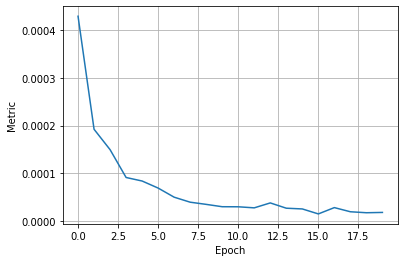

END OF EPOCH 20/20


In [ ]:
# TRAIN
fix_seed(SEED)

best_au = 1.0
best_state = None

for n in range(TaskConfig.num_epochs):

    train_epoch(model, opt, train_loader,
                melspec_train, config.device)

    au_fa_fr = validation(model, val_loader,
                          melspec_val, config.device)
    history['val_metric'].append(au_fa_fr)

    if au_fa_fr < best_au:
        best_au = au_fa_fr
        best_state = deepcopy({'model': model.state_dict(), 'optimizer': opt.state_dict()})

    clear_output()
    plt.plot(history['val_metric'])
    plt.ylabel('Metric')
    plt.xlabel('Epoch')
    plt.grid()
    plt.show()

    print(f"END OF EPOCH {n+1}/{TaskConfig.num_epochs}")

In [ ]:
history

defaultdict(list,
            {'val_metric': [0.00042878619634633915,
              0.0001922684155161608,
              0.0001496064178587216,
              9.138105610971695e-05,
              8.401113484703162e-05,
              6.922951948859312e-05,
              5.0175140062071445e-05,
              3.970209405720282e-05,
              3.513095261006358e-05,
              3.0225628498381525e-05,
              3.008837490401573e-05,
              2.7868447203838446e-05,
              3.8180369424016785e-05,
              2.7122503756198233e-05,
              2.5582876480268826e-05,
              1.5169505951211421e-05,
              2.837568874823379e-05,
              1.9692907017701686e-05,
              1.763410310221469e-05,
              1.8278598240975838e-05]})

In [ ]:
torch.save({
    'model': model.state_dict(),
    'optimizer': opt.state_dict()
}, 'baseline.pt')

In [ ]:
torch.save(best_state, 'baseline_best.pt')

In [ ]:
checkpoint = torch.load('baseline.pt')
model.load_state_dict(checkpoint['model'])
opt.load_state_dict(checkpoint['optimizer'])

In [ ]:
validation(model, val_loader, melspec_val, config.device)

102it [00:05, 19.23it/s]


1.8278598240975838e-05

In [ ]:
checkpoint = torch.load('baseline_best.pt')
model.load_state_dict(checkpoint['model'])
opt.load_state_dict(checkpoint['optimizer'])

In [ ]:
validation(model, val_loader, melspec_val, config.device)

102it [00:05, 19.18it/s]


1.5169505951211421e-05

# Streaming

Предсказывать при каждом новом фрейме может быть слишком расточительно + сеть обучалась с большим страйдом, так что при обработке пофреймово (читай с единичным страйдом) можем получить смещенные данные (может пострадать GRU, которая, возможно, уловила с какой периодичностью забывать прошлое). Для гибкости я добавил параметр `streaming_step_size`, который делает так, чтобы все пересчитывалось с другой периодичностью (например, можно указать параметр равный страйду свертки, чтобы все было как в обучении).

Из-за того, что пересчет может делаться не каждый фрейм, то есть предсказание не будет меняться, я добавил кэш для предсказания.

Наконец, я добавил более умный пересчет внимания: вместо того, чтобы каждый раз пересчитывать скрытый слой для всех элементов и весь софтмакс, я храню экспоненты энергии и их сумму (знаменатель софтмакса), чтобы при новом подсчете считать энергию, ее экспоненту для одного нового элемента, и пересчитать сумму, вычев и добавив по одному элементу.

In [ ]:
class StreamingCRNN(CRNN):
    def __init__(self, config: TaskConfig, max_window_length: int, streaming_step_size: int=1):
        super().__init__(config)

        self.window = max_window_length
        self.step = streaming_step_size
        self.frame_num = 0

        gru_bidirectional_factor = (2 if config.bidirectional else 1)

        self.register_buffer("mels_buffer",
                             torch.zeros(1, 1, config.n_mels, config.kernel_size[1]))
        
        self.register_buffer("gru_hidden_state",
                             torch.zeros(gru_bidirectional_factor * config.gru_num_layers, 1, config.hidden_size))
        self.register_buffer("gru_outputs",
                             torch.zeros(self.window, gru_bidirectional_factor * config.hidden_size))
        
        self.register_buffer("exp_energies",
                             torch.zeros(self.window, 1))
        self.register_buffer("softmax_denom",
                             torch.zeros(1))
        
        self.register_buffer("cached_prediction",
                             torch.full((2,), 0.5))
        
    
    @torch.no_grad()
    def process_frame(self, frame):
        # frame is (n_mels, )

        # update frame buffer
        self.mels_buffer = self._add_to_tensor(self.mels_buffer, frame, -1)
        self.frame_num += 1

        if self.frame_num % self.step == 0:
            # conv->gru->prediction
            conv_output = self.conv(self.mels_buffer).transpose(-1, -2)  # (1, 1, hid_dim)
            gru_output, self.gru_hidden_state = self.gru(conv_output, self.gru_hidden_state)

            self.gru_outputs = self._add_to_tensor(self.gru_outputs, gru_output.squeeze(), 0)

            # we calculate only new energy as we store previous
            last_exp_energy = torch.exp(self.attention.energy(self.gru_outputs[-1]))
            self.softmax_denom += (last_exp_energy - self.exp_energies[0])
            self.exp_energies = self._add_to_tensor(self.exp_energies, last_exp_energy, 0)

            alpha = self.exp_energies / self.softmax_denom
            attention_output = (self.gru_outputs * alpha).sum(dim=-2)

            self.cached_prediction = F.softmax(self.classifier(attention_output), dim=-1)
        
        return self.cached_prediction

    
    def load_from_crnn(self, model: CRNN):
        state = self.state_dict()
        state.update(model.state_dict())
        self.load_state_dict(state)
        return self


    def reset(self):
        self.mels_buffer.zero_()
        self.gru_hidden_state.zero_()
        self.gru_outputs.zero_()
        self.exp_energies.zero_()
        self.softmax_denom.zero_()
        self.cached_prediction.fill_(0.5)
        self.frame = 0
        return self

    
    def _add_to_tensor(self, tensor, new_elem, dim):
        """
        adds new element to tensor in last place at dim and shifts previous elements back
        @param tensor: tensor to which new_elem will be added
        @param new_elem: tensor which will be added to tensor, its size should match (or broadcast) tensors everywhere but dim
        @param dim: dimension on which new_elem will be added

        @returns: new tensor with new_elem in it
        """
        tensor = tensor.transpose(0, dim)
        new_tensor = tensor.clone()

        new_tensor[:-1] = tensor[1:]
        new_tensor[-1] = new_elem.reshape(new_tensor[-1].size())

        new_tensor = new_tensor.transpose(0, dim)
        tensor = tensor.transpose(0, dim)
        return new_tensor


In [ ]:
streamingCRNN = StreamingCRNN(config, 20, streaming_step_size=config.stride[1]).to(config.device)
streamingCRNN.load_from_crnn(model).reset()


StreamingCRNN(
  (conv): Sequential(
    (0): Conv2d(1, 8, kernel_size=(5, 20), stride=(2, 8))
    (1): Flatten(start_dim=1, end_dim=2)
  )
  (gru): GRU(144, 64, num_layers=2, batch_first=True, dropout=0.1)
  (attention): Attention(
    (energy): Sequential(
      (0): Linear(in_features=64, out_features=64, bias=True)
      (1): Tanh()
      (2): Linear(in_features=64, out_features=1, bias=True)
    )
  )
  (classifier): Linear(in_features=64, out_features=2, bias=True)
)

In [ ]:
val_batch, val_batch_labels = next(iter(val_loader))
val_batch, val_batch_labels = val_batch.to(config.device), val_batch_labels.to(config.device)
val_batch = melspec_val(val_batch)
val_example = val_batch[0].transpose(-1, -2)
val_example.size()

torch.Size([101, 40])

In [ ]:
for i in range(config.stride[1] + 1):
    print(streamingCRNN.process_frame(val_example[i]))

tensor([0.5000, 0.5000], device='cuda:0')
tensor([0.5000, 0.5000], device='cuda:0')
tensor([0.5000, 0.5000], device='cuda:0')
tensor([0.5000, 0.5000], device='cuda:0')
tensor([0.5000, 0.5000], device='cuda:0')
tensor([0.5000, 0.5000], device='cuda:0')
tensor([0.5000, 0.5000], device='cuda:0')
tensor([0.5418, 0.4582], device='cuda:0')
tensor([0.5418, 0.4582], device='cuda:0')


Проведем следующий эксперимент: возьмем 10 записей, в которых нет ключевого слова, и 2, в которой есть; поместим их в разные места и понаблюдаем, как меняется вероятность ключевого слова. Поскольку в torch датасете, они западены, возьмем из датафрейма.

In [ ]:
fix_seed(0)

positive = np.random.choice(val_set.csv[val_set.csv.label == 1].index.values, size=2, replace=False).tolist()
negative = np.random.choice(val_set.csv[val_set.csv.label == 0].index.values, size=10, replace=False).tolist()

samples = negative[:3] + [positive[0]] + negative[3:7] + [positive[1]] + negative[7:]

sample_wavs = []
sample_labels = []

for idx in samples:
    elem = val_set[idx]
    wav = elem['wav'].to(config.device)
    label = elem['label']

    sample_wavs.append(melspec_val(wav).transpose(0, 1))
    sample_labels.append(label)

sample_lens = [t.size(0) for t in sample_wavs]
sample_cumlens = np.cumsum([0] + sample_lens)

big_wav = torch.cat(sample_wavs)
big_wav.size()

torch.Size([1210, 40])

In [ ]:
streamingCRNN = StreamingCRNN(config, 20, streaming_step_size=config.stride[1]).to(config.device)
streamingCRNN.load_from_crnn(model).reset()

probs = []
for frame in big_wav:
    probs.append(streamingCRNN.process_frame(frame)[1].item())

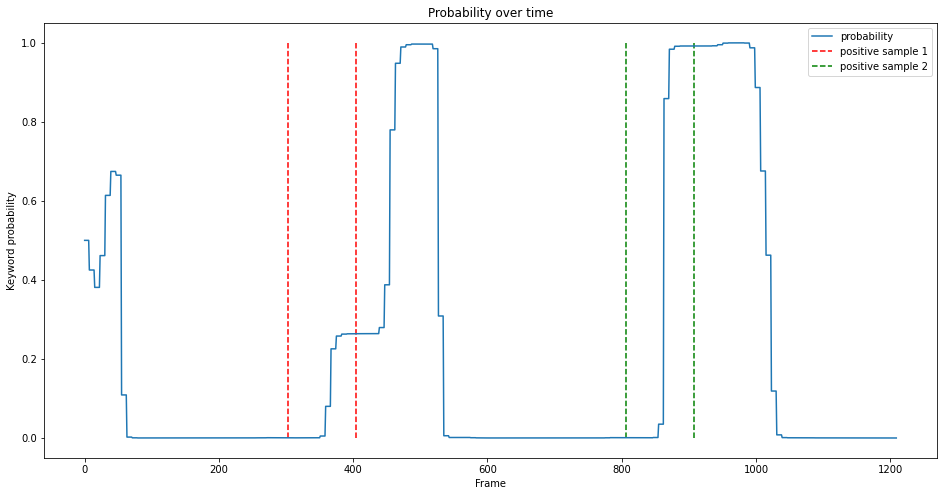

In [ ]:
fig, ax = plt.subplots(figsize=(16, 8))

ax.plot(probs, label='probability')
ax.set_xlabel('Frame')
ax.set_ylabel('Keyword probability')

colors = ['red', 'green']
positive_labels = np.nonzero(sample_labels)[0]
for i, pos in enumerate(positive_labels):
    ax.vlines(sample_cumlens[pos], 0, 1, color=colors[i], linestyles='dashed', label=f'positive sample {i+1}')
    ax.vlines(sample_cumlens[pos+1], 0, 1, color=colors[i], linestyles='dashed')

ax.set_title('Probability over time')

plt.legend()
plt.show()

Это был запуск с дефолтными параметрами. Мы видим, что в самом начале модель колбасит, потому что контекстное окно некоторое время заполняется (чтобы полностью заполнить его требуется `window_size * step_size = 20 * 8 = 160` фреймов, но для адекватного качества, судя по графику, требуется меньше ~70). Точно по этой же причине модель еще некоторое время выдает высокую вероятность, даже когда слово закончилось, и низкую - когда только началось.

Если это важно, то это можно обойти 2мя путями: либо вручную сбрасывать состояние после триггера (например, триггер при N фреймов с высокой вероятностью), либо уменьшить параметры выше, тогда контекст будет быстрее обновляться (но так можно потерять в качестве).

Для интереса попробуем второй путь.

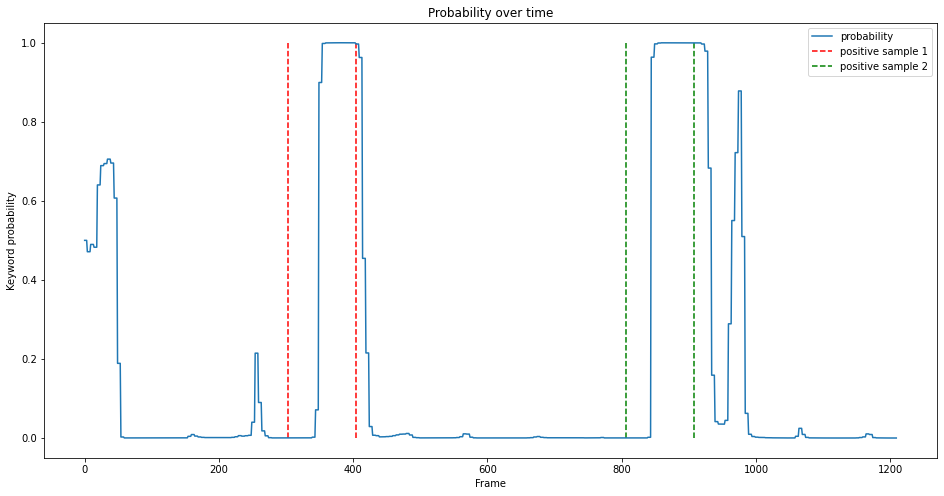

In [ ]:
streamingCRNN = StreamingCRNN(config, 8, streaming_step_size=5).to(config.device)
streamingCRNN.load_from_crnn(model).reset()

probs = []
for frame in big_wav:
    probs.append(streamingCRNN.process_frame(frame)[1].item())

fig, ax = plt.subplots(figsize=(16, 8))

ax.plot(probs, label='probability')
ax.set_xlabel('Frame')
ax.set_ylabel('Keyword probability')

colors = ['red', 'green']
positive_labels = np.nonzero(sample_labels)[0]
for i, pos in enumerate(positive_labels):
    ax.vlines(sample_cumlens[pos], 0, 1, color=colors[i], linestyles='dashed', label=f'positive sample {i+1}')
    ax.vlines(sample_cumlens[pos+1], 0, 1, color=colors[i], linestyles='dashed')

ax.set_title('Probability over time')

plt.legend()
plt.show()

Видим, что задержка после триггера уменьшилась, но появились ложные пики (так как учитываем меньше контекста), то есть стоит перепроверять пороги для срабатывания.

# Optimization & Estimations

Сравнивать будем на батче из одного элемента (типичный инференс)

In [ ]:
%pip install thop

In [ ]:
from thop import profile, clever_format

def get_size_in_megabytes(model):
    params_byte = sum([p.numel() * p.element_size() for p in model.parameters() if p.requires_grad])
    #param_size = next(model.parameters()).element_size()
    return (params_byte) / (2 ** 20)

In [ ]:
print(f"Baseline model size = {get_size_in_megabytes(model):.4f} Mb")

Baseline model size = 0.2687 Mb


In [ ]:
baseline_macs, baseline_params = profile(model, (torch.randn(1, config.n_mels, 100).cuda(), ))
print("Baseline MACs/params: ", clever_format([baseline_macs, baseline_params], "%.3f"))

[INFO] Register count_convNd() for <class 'torch.nn.modules.conv.Conv2d'>.
[WARN] Cannot find rule for <class 'torch.nn.modules.flatten.Flatten'>. Treat it as zero Macs and zero Params.
[WARN] Cannot find rule for <class 'torch.nn.modules.container.Sequential'>. Treat it as zero Macs and zero Params.
[INFO] Register count_gru() for <class 'torch.nn.modules.rnn.GRU'>.
[INFO] Register count_linear() for <class 'torch.nn.modules.linear.Linear'>.
[WARN] Cannot find rule for <class 'torch.nn.modules.activation.Tanh'>. Treat it as zero Macs and zero Params.
[WARN] Cannot find rule for <class '__main__.Attention'>. Treat it as zero Macs and zero Params.
[WARN] Cannot find rule for <class '__main__.CRNN'>. Treat it as zero Macs and zero Params.
Baseline MACs/params:  ('933.808K', '70.443K')


Также интересно сколько занимают отдельные части, которые будем менять.

In [ ]:
print(f"conv = {get_size_in_megabytes(model.conv)} Mb")
print(f"gru = {get_size_in_megabytes(model.gru)} Mb")
print(f"attn = {get_size_in_megabytes(model.attention)} Mb")
print(f"cls = {get_size_in_megabytes(model.classifier)} Mb")

conv = 0.003082275390625 Mb
gru = 0.2490234375 Mb
attn = 0.016117095947265625 Mb
cls = 0.00049591064453125 Mb


Больше всего GRU, она будет в приоритете.

## Distillation

In [ ]:
Ts = [1, 2, 4, 8]
coefs = [0.5, 1.0, 1.5]
teacher = deepcopy(model)

In [ ]:
def train_student_epoch(student, teacher, optimizer, T=1.0, coef=1.0):
    student.train()
    for i, (batch, labels) in tqdm(enumerate(train_loader), total=len(train_loader)):
        batch, labels = batch.to(config.device), labels.to(config.device)
        batch = melspec_train(batch)

        optimizer.zero_grad()

        logits = student(batch)
        with torch.no_grad():
            teacher_probs = F.softmax(teacher(batch) / T, dim=-1)

        probs = F.softmax(logits, dim=-1)

        hard_loss = F.cross_entropy(logits, labels)
        soft_loss = ((-torch.log(probs) / T) * teacher_probs).sum(dim=-1).mean()
        loss = soft_loss + coef * hard_loss

        loss.backward()
        torch.nn.utils.clip_grad_norm_(student.parameters(), 5)

        optimizer.step()

        # logging
        argmax_probs = torch.argmax(probs, dim=-1)
        FA, FR = count_FA_FR(argmax_probs, labels)
        acc = torch.sum(argmax_probs == labels) / torch.numel(argmax_probs)

    return acc

def train_student(student, teacher, optimizer, n_epochs=TaskConfig.num_epochs, T=1.0, coef=1.0, scheduler=None):
    teacher.eval()
    history = defaultdict(list)

    best_metric = 1.0
    best_state = deepcopy(student.state_dict())
    best_epoch = None

    for n in range(n_epochs):
        train_student_epoch(student, teacher, optimizer, T, coef)

        au_fa_fr = validation(student, val_loader,
                            melspec_val, config.device)
        history['val_metric'].append(au_fa_fr)

        if scheduler is not None:
            scheduler.step()

        if au_fa_fr < best_metric:
            best_metric = au_fa_fr
            best_state = deepcopy(student.state_dict())
            best_epoch = n

        clear_output()
        plt.plot(history['val_metric'])
        plt.ylabel('Metric')
        plt.xlabel('Epoch')
        plt.grid()
        plt.show()

        print(f"END OF EPOCH {n+1}/{n_epochs}")
    
    student.load_state_dict(best_state)

    return student, history['val_metric'][best_epoch]

In [ ]:
def sweep_students(student_config, teacher, Ts, coefs, save_name='student.pt'):
    best_metric = 1.0
    best_state = None

    history = [] # (T, coef, metric)

    for i, (coef, T) in enumerate(product(coefs, Ts)):
        print(f"student {i+1}/{len(Ts) * len(coefs)}")
        print(f"T={T}, coef={coef}")
        student = CRNN(student_config).to(config.device)
        optimizer = torch.optim.Adam(
            student.parameters(),
            lr=config.learning_rate,
            weight_decay=config.weight_decay
        )
        student, metric = train_student(student, teacher, optimizer, T=T, coef=coef)

        if metric < best_metric:
            best_metric = metric
            best_state = deepcopy(student.state_dict())
        
        history.append((T, coef, metric))

    model = CRNN(student_config).to(config.device)
    model.load_state_dict(best_state)

    torch.save(best_state, save_name)

    return model, history


Поскольку я перебираю гиперпараметры, я хочу сначала попробовать довольно жесткую дистилляцию (к слову оценить MACs и размер можно заранее), а если не получится, то немного увеличу модель. Также можно увеличивать страйд и ядро, увеличивая число параметров, но уменьшая (из-за страйда и отсутствия паддинга) вычисления. Сейчас важнее скорость, потому что много памяти можно сократить и с квантизацией, а про скорость непонятно (как минимум в MACs не изменится).

Размеры подобраны так, чтобы MACs было в 10 раз меньше baseline.

In [ ]:
fix_seed(SEED)

distil_config_01 = TaskConfig(hidden_size=20, cnn_out_channels=3, kernel_size=(9, 20), stride=(4, 10))
student_01 = CRNN(distil_config_01)
get_size_in_megabytes(student_01), profile(student_01, (torch.randn(1, config.n_mels, 100), ))

[INFO] Register count_convNd() for <class 'torch.nn.modules.conv.Conv2d'>.
[WARN] Cannot find rule for <class 'torch.nn.modules.flatten.Flatten'>. Treat it as zero Macs and zero Params.
[WARN] Cannot find rule for <class 'torch.nn.modules.container.Sequential'>. Treat it as zero Macs and zero Params.
[INFO] Register count_gru() for <class 'torch.nn.modules.rnn.GRU'>.
[INFO] Register count_linear() for <class 'torch.nn.modules.linear.Linear'>.
[WARN] Cannot find rule for <class 'torch.nn.modules.activation.Tanh'>. Treat it as zero Macs and zero Params.
[WARN] Cannot find rule for <class '__main__.Attention'>. Treat it as zero Macs and zero Params.
[WARN] Cannot find rule for <class '__main__.CRNN'>. Treat it as zero Macs and zero Params.


(0.02405548095703125, (92956.0, 6306.0))

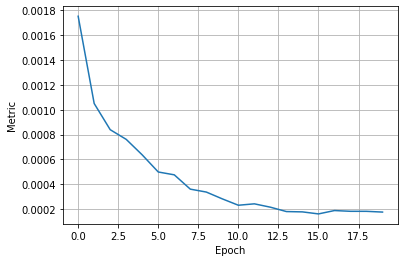

END OF EPOCH 20/20


In [ ]:
fix_seed(SEED)
student, history = sweep_students(distil_config_01, teacher, Ts, coefs, save_name='distil_01.pt')

In [ ]:
with open('sweep-stats', 'w') as f:
    for hist in history:
        f.write(f"{hist[0]}\t{hist[1]}\t{hist[2]}\n")

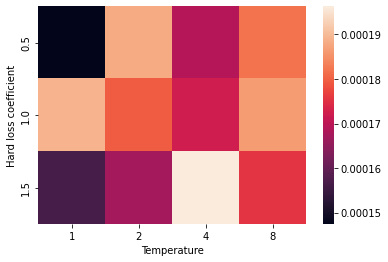

In [ ]:
import seaborn as sns
metric_map = np.array([x[2] for x in history]).reshape((len(coefs), len(Ts)))

ax = sns.heatmap(metric_map, xticklabels=Ts, yticklabels=coefs)
ax.set_xlabel("Temperature")
ax.set_ylabel("Hard loss coefficient")

plt.show()

Какой-то прямой закономерности от температуры и коэффициента перед hard loss я не нашел, однако заметил, что сеть почти во всех случаях как-будто не доучилась, поэтому пару лучших (с лучшими параметрами), но подольше и со scheduler'ом

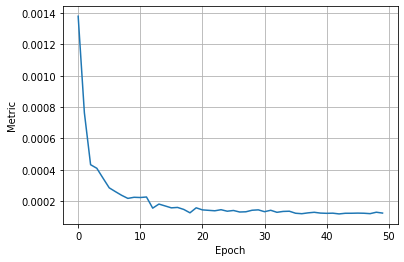

END OF EPOCH 50/50


In [ ]:
fix_seed(SEED)

T = 1.0
coef = 0.5
n_student_epochs = 50

student_01 = CRNN(distil_config_01).to(config.device)
optimizer = torch.optim.Adam(
    student_01.parameters(),
    lr=config.learning_rate,
    weight_decay=config.weight_decay
)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 20, 0.3)

student_01, student_01_au = train_student(student_01, teacher, optimizer,
                                          n_epochs=n_student_epochs,
                                          T=T,
                                          coef=coef,
                                          scheduler=scheduler)

In [ ]:
torch.save(student_01.state_dict(), "student_01.pt")
print(f"Student_01 best au-fa-fr = {student_01_au}")

Student_01 best au-fa-fr = 0.00011867065119818659




---



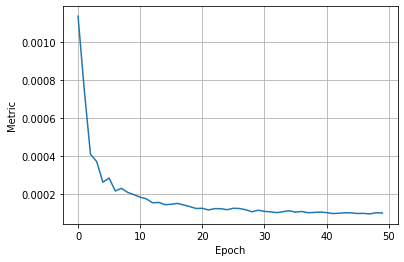

END OF EPOCH 50/50


In [ ]:
fix_seed(SEED)

T = 1.0
coef = 1.5
n_student_epochs = 50

student_02 = CRNN(distil_config_01).to(config.device)
optimizer = torch.optim.Adam(
    student_02.parameters(),
    lr=config.learning_rate,
    weight_decay=config.weight_decay
)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 20, 0.3)

student_02, student_02_au = train_student(student_02, teacher, optimizer,
                                          n_epochs=n_student_epochs,
                                          T=T,
                                          coef=coef,
                                          scheduler=scheduler)

In [ ]:
torch.save(student_02.state_dict(), "student_02.pt")
print(f"Student_02 best au-fa-fr = {student_02_au}")

Student_02 best au-fa-fr = 9.55165665834343e-05




---



Топ-2 не получилось, но в это время я нашел [статейку](https://arxiv.org/pdf/1503.02531.pdf), в которой утверждается, что хорошие параметры для температуры - от 2.5 до 4. Лучший для этого коэффициент у меня - 0.5. Попробуем еще раз.

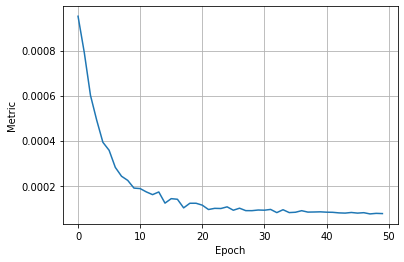

END OF EPOCH 50/50


In [ ]:
fix_seed(SEED)

T = 4.0
coef = 0.5
n_student_epochs = 50

student_03 = CRNN(distil_config_01).to(config.device)
optimizer = torch.optim.Adam(
    student_03.parameters(),
    lr=config.learning_rate,
    weight_decay=config.weight_decay
)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 20, 0.3)

student_03, student_03_au = train_student(student_03, teacher, optimizer,
                                          n_epochs=n_student_epochs,
                                          T=T,
                                          coef=coef,
                                          scheduler=scheduler)

In [ ]:
torch.save(student_03.state_dict(), "student_03.pt")
print(f"Student_03 best au-fa-fr = {student_03_au}")

Student_03 best au-fa-fr = 7.454063683579143e-05


Стало лучше, но все равно не хватило, попробуем увеличить что нибудь. Но перед этим посмотрим, как меняется MACs при изменении различных параметров (в частности, `hidden_size` и `cnn_out_channels`).

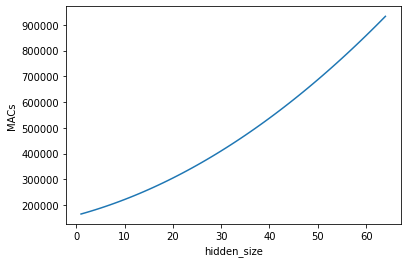

In [ ]:
all_macs = []

for hs in range(1, 65):
    d_conf = TaskConfig(hidden_size=hs)
    d_model = CRNN(d_conf)
    macs, _ = profile(d_model, (torch.randn(1, config.n_mels, 100), ))
    all_macs.append(macs)

clear_output()
plt.plot(np.arange(1, 65), all_macs)
plt.xlabel('hidden_size')
plt.ylabel('MACs')

plt.show()

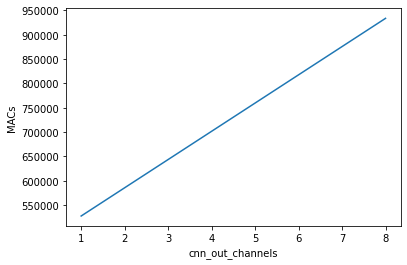

In [ ]:
all_macs = []

for ch in range(1, 9):
    d_conf = TaskConfig(cnn_out_channels=ch)
    d_model = CRNN(d_conf)
    macs, _ = profile(d_model, (torch.randn(1, config.n_mels, 100), ))
    all_macs.append(macs)

clear_output()
plt.plot(np.arange(1, 9), all_macs)
plt.xlabel('cnn_out_channels')
plt.ylabel('MACs')

plt.show()

Здесь видно, что MACs квадратичны относительно `hidden_size` и линейны относительно `cnn_out_channels`, поэтому логично уменьшать первое и нестрашно увеличивать второе.

Попробуем увеличить `cnn_out_channels`

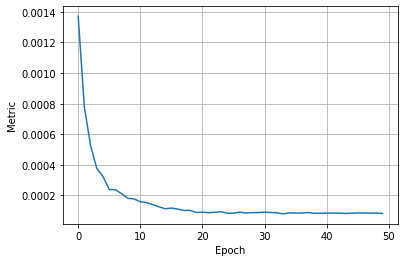

END OF EPOCH 50/50


In [ ]:
fix_seed(SEED)

T = 4.0
coef = 0.5
n_student_epochs = 50

distil_config_02 = TaskConfig(hidden_size=20, cnn_out_channels=4, kernel_size=(9, 20), stride=(4, 10))
student_04 = CRNN(distil_config_02).to(config.device)
optimizer = torch.optim.Adam(
    student_04.parameters(),
    lr=config.learning_rate,
    weight_decay=config.weight_decay
)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 20, 0.3)

student_04, student_04_au = train_student(student_04, teacher, optimizer,
                                          n_epochs=n_student_epochs,
                                          T=T,
                                          coef=coef,
                                          scheduler=scheduler)

In [ ]:
student_04_au

7.943999339989237e-05

In [ ]:
tmp_student = CRNN(distil_config_02)

profile_info = profile(tmp_student, (torch.randn(1, config.n_mels, 100), ))

clear_output()
print("Student_04")
print(f"Size: {get_size_in_megabytes(tmp_student)} Mb")
print("MACs and params:", profile_info)

Student_04
Size: 0.026576995849609375 Mb
MACs and params: (110308.0, 6967.0)




---

Продолжаем увеличивать. На этот раз `hidden_size=32`



In [ ]:
distil_config_03 = TaskConfig(hidden_size=32, cnn_out_channels=4, kernel_size=(9, 20), stride=(4, 10))

tmp_student = CRNN(distil_config_03)

profile_info = profile(tmp_student, (torch.randn(1, config.n_mels, 100), ))

clear_output()
print("Student_05")
print(f"Size: {get_size_in_megabytes(tmp_student)} Mb")
print("MACs and params:", profile_info)

Student_05
Size: 0.055507659912109375 Mb
MACs and params: (179776.0, 14551.0)


In [ ]:
fix_seed(SEED)

T = 4.0
coef = 0.5
n_student_epochs = 50

student_05 = CRNN(distil_config_03).to(config.device)
optimizer = torch.optim.Adam(
    student_05.parameters(),
    lr=config.learning_rate,
    weight_decay=config.weight_decay
)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 20, 0.3)

student_05, student_05_au = train_student(student_05, teacher, optimizer,
                                          n_epochs=n_student_epochs,
                                          T=T,
                                          coef=coef,
                                          scheduler=scheduler)

In [92]:
student_05_au

6.573253660605577e-05



---

Уберем scheduler, т.к. кажется, что слишком замедляется обучение.

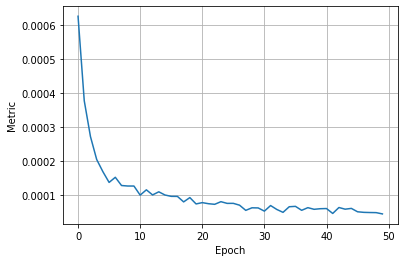

END OF EPOCH 50/50


In [93]:
fix_seed(SEED)

T = 4.0
coef = 0.5
n_student_epochs = 50

student_06 = CRNN(distil_config_03).to(config.device)
optimizer = torch.optim.Adam(
    student_06.parameters(),
    lr=config.learning_rate,
    weight_decay=config.weight_decay
)

student_06, student_06_au = train_student(student_06, teacher, optimizer,
                                          n_epochs=n_student_epochs,
                                          T=T,
                                          coef=coef)

In [94]:
student_06_au

4.4523872502749175e-05

In [95]:
torch.save(student_06.state_dict(), 'student_06.pt')

In [123]:
baseline_config = TaskConfig()
distil_config_03 = TaskConfig(hidden_size=32, cnn_out_channels=4, kernel_size=(9, 20), stride=(4, 10))

tmp_base = CRNN(baseline_config)
tmp_student = CRNN(distil_config_03)

base_size = get_size_in_megabytes(tmp_base)
dis_size = get_size_in_megabytes(tmp_student)

base_mac, base_pars = profile(tmp_base, (torch.randn(1, config.n_mels, 100), ))
dis_mac, dis_pars = profile(tmp_student, (torch.randn(1, config.n_mels, 100), ))

clear_output()
print("Student_06")
print(f"Memory ratio: {base_size / dis_size}")
print(f"MACs ratio: {base_mac / dis_mac}")
print(f"Params ratio: {base_pars / dis_pars}")

Student_06
Memory ratio: 4.841110576592674
MACs ratio: 5.1942862228551085
Params ratio: 4.841110576592674




---

Учитывая успех (и довольно большой гэп до 5e-5 * 1.1) попробуем уменьшить еще. `hidden_size=16`

In [110]:
distil_config_04 = TaskConfig(hidden_size=16, cnn_out_channels=4, kernel_size=(9, 20), stride=(4, 10))

tmp_student = CRNN(distil_config_04)

profile_info = profile(tmp_student, (torch.randn(1, config.n_mels, 100), ))

clear_output()
print("Student_07")
print(f"Size: {get_size_in_megabytes(tmp_student)} Mb")
print("MACs and params:", profile_info)

Student_07
Size: 0.019374847412109375 Mb
MACs and params: (92912.0, 5079.0)


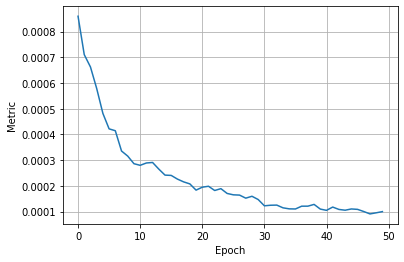

END OF EPOCH 50/50


In [98]:
fix_seed(SEED)

T = 4.0
coef = 0.5
n_student_epochs = 50

student_07 = CRNN(distil_config_04).to(config.device)
optimizer = torch.optim.Adam(
    student_07.parameters(),
    lr=config.learning_rate,
    weight_decay=config.weight_decay
)

student_07, student_07_au = train_student(student_07, teacher, optimizer,
                                          n_epochs=n_student_epochs,
                                          T=T,
                                          coef=coef)

In [99]:
student_07_au

9.082010663709149e-05



---

Немного увеличим `hidden_size=20`.

In [122]:
distil_config_05 = TaskConfig(hidden_size=20, cnn_out_channels=4, kernel_size=(9, 20), stride=(4, 10))

tmp_student = CRNN(distil_config_05)

profile_info = profile(tmp_student, (torch.randn(1, config.n_mels, 100), ))

clear_output()
print("Student_08")
print(f"Size: {get_size_in_megabytes(tmp_student)} Mb")
print("MACs and params:", profile_info)

Student_08
Size: 0.026576995849609375 Mb
MACs and params: (110308.0, 6967.0)


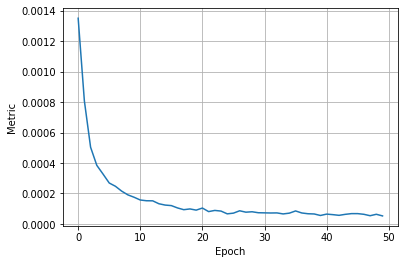

END OF EPOCH 50/50


In [117]:
fix_seed(SEED)

T = 4.0
coef = 0.5
n_student_epochs = 50

student_08 = CRNN(distil_config_05).to(config.device)
optimizer = torch.optim.Adam(
    student_08.parameters(),
    lr=config.learning_rate,
    weight_decay=config.weight_decay
)

student_08, student_08_au = train_student(student_08, teacher, optimizer,
                                          n_epochs=n_student_epochs,
                                          T=T,
                                          coef=coef)

In [118]:
student_08_au

5.286053647357623e-05

In [119]:
torch.save(student_08.state_dict(), 'student_08.pt')



---

Бинго! попали в необходимую границу 5.5e-5. Посчитаем во сколько раз мы превзошли бейзлайн.

In [121]:
baseline_config = TaskConfig()
distil_config_05 = TaskConfig(hidden_size=20, cnn_out_channels=4, kernel_size=(9, 20), stride=(4, 10))

tmp_base = CRNN(baseline_config)
tmp_student = CRNN(distil_config_05)

base_size = get_size_in_megabytes(tmp_base)
dis_size = get_size_in_megabytes(tmp_student)

base_mac, base_pars = profile(tmp_base, (torch.randn(1, config.n_mels, 100), ))
dis_mac, dis_pars = profile(tmp_student, (torch.randn(1, config.n_mels, 100), ))

clear_output()
print("Student_08")
print(f"Memory ratio: {base_size / dis_size}")
print(f"MACs ratio: {base_mac / dis_mac}")
print(f"Params ratio: {base_pars / dis_pars}")

Student_08
Memory ratio: 10.110951629108655
MACs ratio: 8.465460347390941
Params ratio: 10.110951629108655


## Quantization

Здесь я хочу попробовать квантизовать лучшие к текущему моменту модели. Соберем их вместе

In [217]:
all_configs = [
    TaskConfig(), 
    TaskConfig(hidden_size=32, cnn_out_channels=4, kernel_size=(9, 20), stride=(4, 10)),
    TaskConfig(hidden_size=20, cnn_out_channels=4, kernel_size=(9, 20), stride=(4, 10))
]
model_files = ['baseline_best.pt', 'student_06.pt', 'student_08.pt']
names = ['baseline', 'student_h32_c4', 'student_h20_c4']

models = []
for conf, mf in zip(all_configs, model_files):
    tmp_model = CRNN(conf)
    checkpoint = torch.load(mf)
    if mf == "baseline_best.pt":
        checkpoint = checkpoint['model']
    
    tmp_model.load_state_dict(checkpoint)
    tmp_model.eval()
    models.append(tmp_model)

In [218]:
q_models = []
q_names = []

for model, name in zip(models, names):
    q_model = torch.quantization.quantize_dynamic(
        model, {torch.nn.GRU, torch.nn.Linear}, dtype=torch.qint8
    )
    q_model.eval()
    q_models.append(q_model)
    q_names.append(name + "_q")

In [219]:
models += q_models
names += q_names

In [220]:
f16_model_baseline = torch.quantization.quantize_dynamic(
        models[0], {torch.nn.GRU, torch.nn.Linear}, dtype=torch.float16
)


Оценим все параметры. Размер квантизованных моделей той функцией не оценить, но мы знаем, что квантизовали, то есть можем использовать неквантизованную модель для оценки. Делим на 4 из-за того, что переводим float32 в qint8.

In [216]:
def estimate_quantized(model: CRNN):
    return (get_size_in_megabytes(model.conv)
            + get_size_in_megabytes(model.gru) / 4
            + get_size_in_megabytes(model.attention) / 4
            + get_size_in_megabytes(model.classifier) / 4)

In [166]:
estimations = defaultdict(list)
cpu_val_melspec = deepcopy(melspec_val)
cpu_val_melspec = cpu_val_melspec.melspec.to('cpu')

for i, model in enumerate(models):
    no_quant = i < 3
    model = model.cuda() if no_quant else model.cpu()
    auc = validation(model,
                     val_loader,
                     (melspec_val if no_quant else cpu_val_melspec),
                     (config.device if no_quant else 'cpu'))
    
    estimations['metric'].append(auc)
    estimations['size'].append(get_size_in_megabytes(model) if no_quant else estimate_quantized(models[i-3]))

    model = model.cpu()
    macs, n_pars = profile(model, (torch.randn(1, config.n_mels, 100), ))
    estimations['macs'].append(macs)
    estimations['n_pars'].append(n_pars)

    clear_output()

In [167]:
estimations

defaultdict(list,
            {'macs': [933808.0,
              179776.0,
              110308.0,
              159984.0,
              52128.0,
              52128.0],
             'metric': [1.5169505951211421e-05,
              4.4523872502749175e-05,
              5.286053647357623e-05,
              0.005939532929002147,
              0.007526993082568033,
              0.007077257810438166],
             'n_pars': [70443.0, 14551.0, 6967.0, 808.0, 724.0, 724.0],
             'size': [0.2687187194824219,
              0.055507659912109375,
              0.026576995849609375,
              0.06949138641357422,
              0.01594829559326172,
              0.008715629577636719]})

In [221]:
print(f"F16 baseline AUC: {validation(f16_model_baseline, val_loader, cpu_val_melspec, 'cpu')}")

102it [00:09, 10.62it/s]


F16 baseline AUC: 0.0015500167762681374


В чате обсуждалось, что thop не умеет оценивать квантизованные модели, поэтому MACs там различается, но мы знаем, что он должен совпадать. Зато мы хорошо можем сравнить память.

Но стоит заметить, что квантизованные модели имеют качество на порядок хуже.

In [175]:
print('name\t\tauc\t\t\tMACs\t\tSize')
for i, name in enumerate(names):
    print(f"{name}\t{estimations['metric'][i]}\t{estimations['macs'][i%3]}\t{estimations['size'][i]}")

name		auc			MACs		Size
baseline	1.5169505951211421e-05	933808.0	0.2687187194824219
student_h32_c4	4.4523872502749175e-05	179776.0	0.055507659912109375
student_h20_c4	5.286053647357623e-05	110308.0	0.026576995849609375
baseline_q	0.005939532929002147	933808.0	0.06949138641357422
student_h32_c4_q	0.007526993082568033	179776.0	0.01594829559326172
student_h20_c4_q	0.007077257810438166	110308.0	0.008715629577636719


Честно говоря, я немного не понял, почему качество так сильно ухудшилось, хотя однокурсники говорили, что ровно такой метод квантизации хорошо работал. Я предполагаю, что дело в версии торча (к слову квантизованные модели у меня не запускались на GPU, пришлось их обсчитывать на CPU, а в таком случае сравнивать модели на GPU и CPU бессмысленно).

Но давайте порисуем.

Зависимость качества от размера/MACs

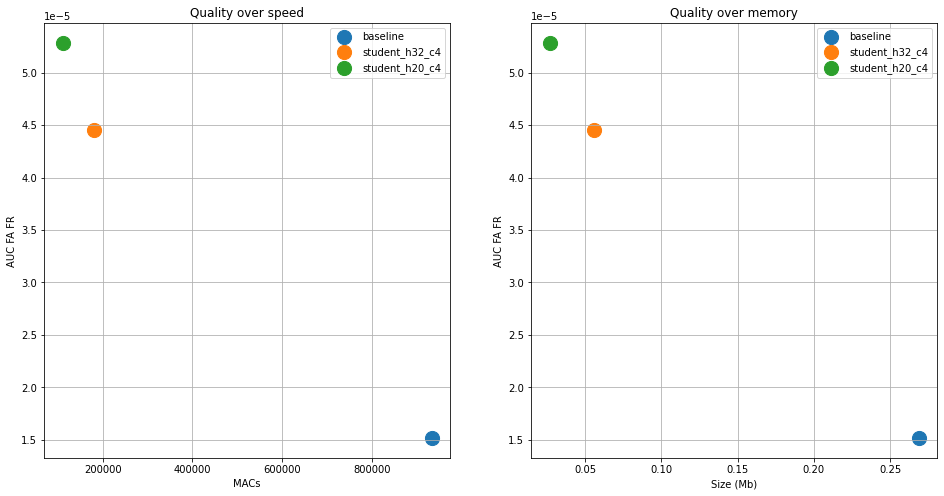

In [202]:
fig, axs = plt.subplots(ncols=2, figsize=(16, 8))

for i in range(3):
    axs[0].scatter([estimations['macs'][i]], [estimations['metric'][i]], label=names[i], s=200)
    axs[1].scatter([estimations['size'][i]], [estimations['metric'][i]], label=names[i], s=200)

axs[0].set_xlabel('MACs')
axs[0].set_ylabel('AUC FA FR')
axs[0].set_title('Quality over speed')
axs[0].grid()
axs[0].legend()

axs[1].set_xlabel('Size (Mb)')
axs[1].set_ylabel('AUC FA FR')
axs[1].set_title('Quality over memory')
axs[1].grid()
axs[1].legend()

plt.show()

Подробнее с квантизацией. Внимание на логарифмическую шкалу по качеству.

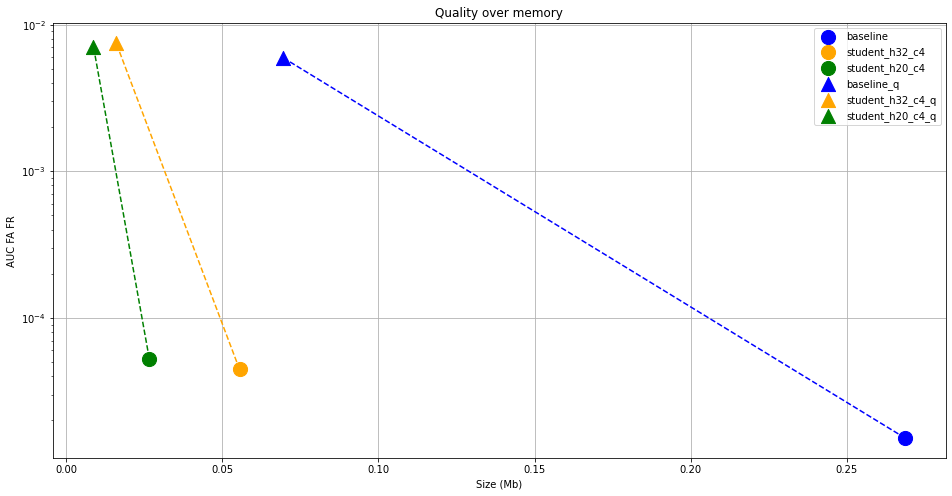

In [201]:
fig, ax = plt.subplots(figsize=(16, 8))

colors = ['blue', 'orange', 'green']
markers = ['o', 'o', 'o', '^', '^', '^']

for i in range(6):
    ax.scatter([estimations['size'][i]], [estimations['metric'][i]], label=names[i], s=200, c=colors[i%3], marker=markers[i])
    if i < 3:
        ax.plot([estimations['size'][i], estimations['size'][i+3]],
                [estimations['metric'][i], estimations['metric'][i+3]],
                c=colors[i],
                linestyle='--')
        
ax.set_xlabel('Size (Mb)')
ax.set_ylabel('AUC FA FR')
ax.set_yscale('log')
ax.set_title('Quality over memory')
ax.grid()
ax.legend()

plt.show()